# Load and explore data

In [1]:
# Load necessary libraries
library(tidyverse)
library(ggplot2)

# Load the dataset
data <- read.csv("input\\cookie_cats.csv")

# convert rentention into lgl
data <- data %>%
  mutate(
    retention_1 = if_else(retention_1 == "True", TRUE, FALSE),
    retention_7 = if_else(retention_7 == "True", TRUE, FALSE)
  )

# Explore the data
glimpse(data)
summary(data)

Warning message:
"package 'tidyverse' was built under R version 4.3.3"
Warning message:
"package 'forcats' was built under R version 4.3.3"
── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.2     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.2     ✔ tibble    3.2.1
✔ lubridate 1.9.2     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


Rows: 90,189
Columns: 5
$ userid         <int> 116, 337, 377, 483, 488, 540, 1066, 1444, 1574, 1587, 1…
$ version        <chr> "gate_30", "gate_30", "gate_40", "gate_40", "gate_40", …
$ sum_gamerounds <int> 3, 38, 165, 1, 179, 187, 0, 2, 108, 153, 3, 0, 30, 39, …
$ retention_1    <lgl> FALSE, TRUE, TRUE, FALSE, TRUE, TRUE, FALSE, FALSE, TRU…
$ retention_7    <lgl> FALSE, FALSE, FALSE, FALSE, TRUE, TRUE, FALSE, FALSE, T…


     userid          version          sum_gamerounds     retention_1    
 Min.   :    116   Length:90189       Min.   :    0.00   Mode :logical  
 1st Qu.:2512230   Class :character   1st Qu.:    5.00   FALSE:50036    
 Median :4995815   Mode  :character   Median :   16.00   TRUE :40153    
 Mean   :4998412                      Mean   :   51.87                  
 3rd Qu.:7496452                      3rd Qu.:   51.00                  
 Max.   :9999861                      Max.   :49854.00                  
 retention_7    
 Mode :logical  
 FALSE:73408    
 TRUE :16781    
                
                
                

# The distribution of game rounds

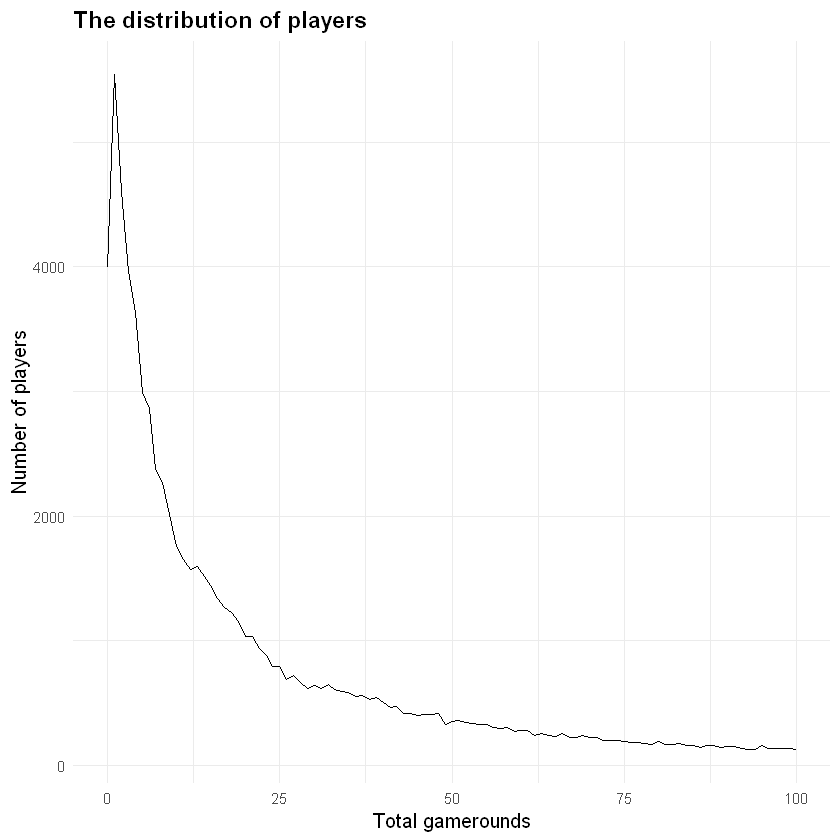

In [2]:
# Counting the number of players for each number of gamerounds
plot_df <- data %>%
  group_by(sum_gamerounds) %>%
  summarize(count = n())

# Plotting the distribution of players that played 0 to 100 game rounds
plot_df %>%
  filter(sum_gamerounds <= 100) %>%
  ggplot(aes(x = sum_gamerounds, y = count)) +
  geom_line() +
  labs(
    title = "The distribution of players",
    x = "Total gamerounds",
    y = "Number of players"
  ) +
  theme_minimal() +
  theme(
    plot.title = element_text(face = "bold", size = 14),
    axis.title.x = element_text(size = 12),
    axis.title.y = element_text(size = 12)
  )

# Prepare the data for A/B Testing Analysis

In [3]:
# Convert boolean columns to numeric
data <- data %>%
  mutate(across(c(retention_1, retention_7), as.numeric))

# Calculate the mean retention rates for day 1 and day 7, and multiply by 100
data_retention <- colMeans(data[c("retention_1", "retention_7")]) * 100

# Calculate the mean retention rates for day 1 and day 7, and multiply by 100
data_rentention <- colMeans(data[c("retention_1", "retention_7")]) * 100

# Print the 1-day and 7-day retention ratios, rounded to 2 decimal places
cat(sprintf("1-day retention ratio: %.2f%% \n7-day retention ratio: %.2f%%",
            round(data_rentention[1], 2), round(data_rentention[2], 2)))

1-day retention ratio: 44.52% 
7-day retention ratio: 18.61%

# Calculating 1-day and 7-day retention for each A/B group

In [4]:
# Perform the aggregation
df_retention_ab <- data %>%
  group_by(version) %>%
  summarize(
    userid_count = n(),
    retention_1_mean = mean(retention_1, na.rm = TRUE),
    retention_7_mean = mean(retention_7, na.rm = TRUE),
    sum_gamerounds_sum = sum(sum_gamerounds, na.rm = TRUE)
  )

# Print the resulting dataframe
print(df_retention_ab)

# A tibble: 2 × 5
  version userid_count retention_1_mean retention_7_mean sum_gamerounds_sum
  <chr>          <int>            <dbl>            <dbl>              <int>
1 gate_30        44700            0.448            0.190            2344795
2 gate_40        45489            0.442            0.182            2333530


# A/B Testing: Bootstrapping


Attaching package: 'gridExtra'


The following object is masked from 'package:dplyr':

    combine




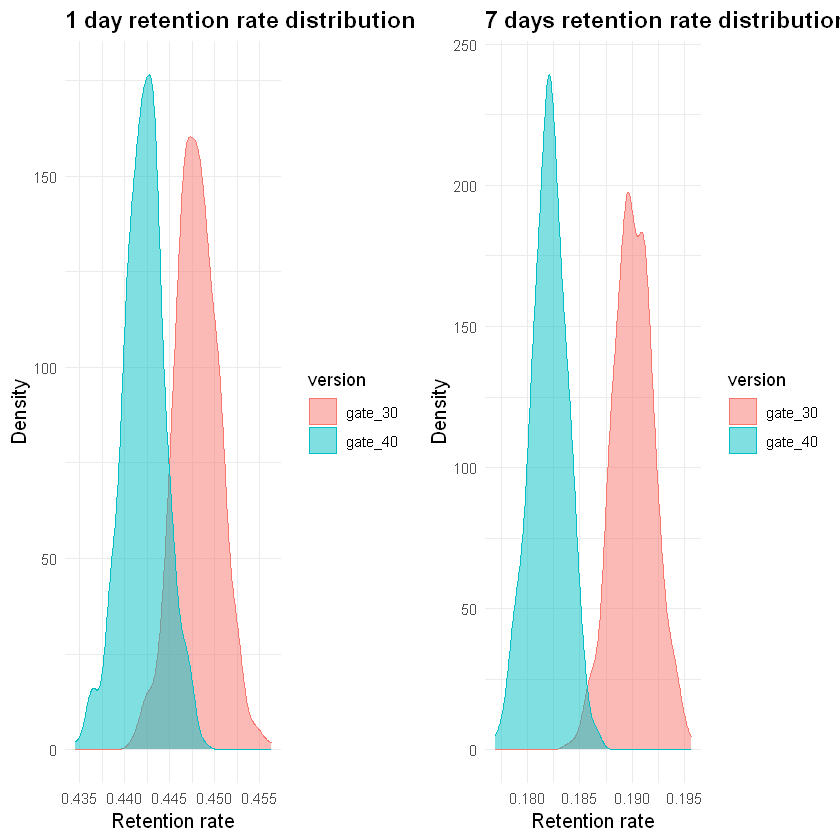

In [5]:
# Initialize lists to store bootstrap results
boot_1d <- list()
boot_7d <- list()

# Perform bootstrapping
set.seed(123)  # For reproducibility
for (i in 1:500) {
  boot_sample <- data %>% sample_frac(replace = TRUE)
  boot_mean_1 <- boot_sample %>% group_by(version) %>% summarize(mean_retention_1 = mean(retention_1, na.rm = TRUE))
  boot_mean_7 <- boot_sample %>% group_by(version) %>% summarize(mean_retention_7 = mean(retention_7, na.rm = TRUE))
  boot_1d[[i]] <- boot_mean_1
  boot_7d[[i]] <- boot_mean_7
}

# Combine the bootstrapped samples into dataframes
boot_1d_df <- bind_rows(boot_1d, .id = "boot_id")
boot_7d_df <- bind_rows(boot_7d, .id = "boot_id")

# Plot Kernel Density Estimate of the bootstrap distributions
p1 <- boot_1d_df %>%
  ggplot(aes(x = mean_retention_1, color = version, fill = version)) +
  geom_density(alpha = 0.5) +
  labs(
    title = "1 day retention rate distribution",
    x = "Retention rate",
    y = "Density"
  ) +
  theme_minimal() +
  theme(
    plot.title = element_text(face = "bold", size = 14),
    axis.title.x = element_text(size = 12),
    axis.title.y = element_text(size = 12)
  )

p2 <- boot_7d_df %>%
  ggplot(aes(x = mean_retention_7, color = version, fill = version)) +
  geom_density(alpha = 0.5) +
  labs(
    title = "7 days retention rate distribution",
    x = "Retention rate",
    y = "Density"
  ) +
  theme_minimal() +
  theme(
    plot.title = element_text(face = "bold", size = 14),
    axis.title.x = element_text(size = 12),
    axis.title.y = element_text(size = 12)
  )

# Arrange plots side by side
library(gridExtra)
grid.arrange(p1, p2, ncol = 2)

# Zooming in on the differences

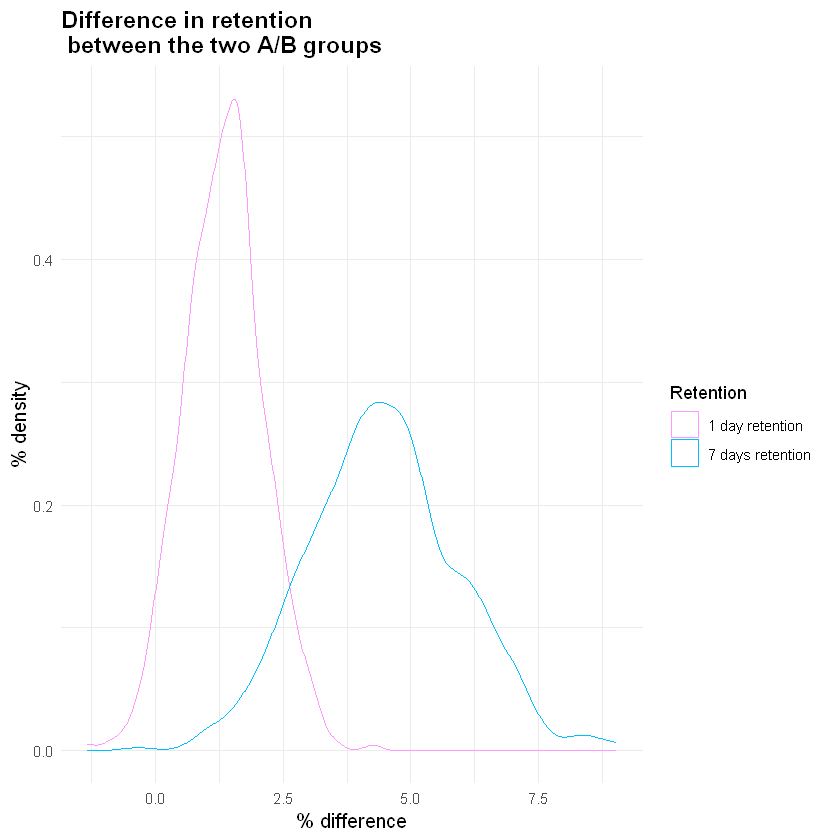

In [6]:
# Adding a column with the % difference between the two A/B groups
boot_1d <- boot_1d_df %>%
  group_by(boot_id) %>%
  mutate(
    diff = ((mean_retention_1[version == "gate_30"] - mean_retention_1[version == "gate_40"]) / mean_retention_1[version == "gate_40"]) * 100
  ) %>%
  ungroup() 

boot_7d <- boot_7d_df %>%
  group_by(boot_id) %>%
  mutate(
    diff = ((mean_retention_7[version == "gate_30"] - mean_retention_7[version == "gate_40"]) / mean_retention_7[version == "gate_40"]) * 100
  ) %>%
  ungroup() 

# Plotting the bootstrap % difference
p <- ggplot() +
  geom_density(data = boot_1d, aes(x = diff, color = "1 day retention"), alpha = 0.5) +
  geom_density(data = boot_7d, aes(x = diff, color = "7 days retention"), alpha = 0.5) +
  labs(
    x = "% difference",
    y = "% density",
    title = "Difference in retention \n between the two A/B groups",
    color = "Retention"
  ) +
  theme_minimal() +
  theme(
    plot.title = element_text(face = "bold", size = 14),
    axis.title.x = element_text(size = 12),
    axis.title.y = element_text(size = 12)
  ) +
  scale_color_manual(values = c("#ff99ff", "#00bfff"), labels = c("1 day retention", "7 days retention"))

print(p)

# Probabities

In [7]:
# Calculating the probability that 1-day retention is greater when the gate is at level 30
prob_1 <- sum(boot_1d$diff > 0) / nrow(boot_1d_df)

# Calculating the probability that 7-days retention is greater when the gate is at level 30
prob_7 <- sum(boot_7d$diff > 0) / nrow(boot_7d_df)

# Pretty printing the probability
cat(sprintf("The probability that 1-day retention is greater when the gate is at level 30: %.2f%%\n", prob_1 * 100))
cat(sprintf("The probability that 7-days retention is greater when the gate is at level 30: %.2f%%\n", prob_7 * 100))

The probability that 1-day retention is greater when the gate is at level 30: 96.00%
The probability that 7-days retention is greater when the gate is at level 30: 99.80%
